# 500 sample run results

Increasing the sample size definitely improved the curve fit, kicking up the tail and hugging the data a lot more closely. Furthermore, it seemed changing the bounds, particularly the lower bound on logT_AGN, helped significantly in improving the results as well.

This took about 8.5hrs to run, which was faster than initially approximated. I'm not too sure how to interpret the contour plots at the moment. They still seem to be really noisy. I'm not sure if this is an artifact of me doing something wrong in the code or merely my initial suspision that more samples were needed. This run is significantly below the minimum needed for three-parameter-space, so I suspect that this is a likely reason why the contour plots seem really messy and, at least to me, hardly readable. However, I think this run was generally successful! The data was once again saved as 'Data/500_sample_test.npy' should it be valuable to refer back to in the future.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import camb
import emcee
import matplotlib as mpl
from matplotlib import pyplot as plt
import corner
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
from IPython.display import display, Math

plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

### Creating "fake" oberservational data

In [2]:
pars_test = camb.set_params(H0=67.5, 
                            ombh2=0.022, 
                            omch2=0.120*1.2, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_A_baryon = 0, 
                            HMCode_eta_baryon = 0, 
                            HMCode_logT_AGN = -10)
                            # zero the HMCode to get a universe without baryonic feedback
results_test = camb.get_transfer_functions(pars_test)
kh_test, _, pk_test = results_test.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

kh_data = kh_test
pk_data = pk_test[0]

pk_err = 0.10*pk_data # creating error

## Using piecing method:

### Creating likelihood function using 'mead2020'

In [3]:
def log_likelihood_mead(theta, x, y, yerr): 
    # theta = [A, eta, logT_AGN] params, x --> kh_data, y --> pk_data, yerr --> pk_err
    A, eta, logT_AGN = theta
    model = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A, 
                           HMCode_eta_baryon = eta, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(model)
    kh, _, pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    pk = pk[0]
    sigma2 = yerr**2
    return -0.5 * np.sum((y - pk)**2 / sigma2 + np.log(sigma2))

In [4]:
nll_mead = lambda *args: -log_likelihood_mead(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood
initial = np.array([3.13, 0.603, 7.8]) # using default HMCode values
soln_mead = minimize(nll_mead, initial, args=(kh_data, pk_data, pk_err))
A_ml_mead, eta_ml_mead, logT_AGN_ml_mead = soln_mead.x # maximum likelihood values
print('"mead" maximum likelihood values:', soln_mead.x)

"mead" maximum likelihood values: [ 3.14322588 -0.38471244  7.8       ]


### Creating likelihood function using 'mead2020_feedback'

In [5]:
def log_likelihood_feedback(theta, x, y, yerr): 
    # theta = [A, eta, logT_AGN] params, x --> kh_data, y --> pk_data, yerr --> pk_err
    A, eta, logT_AGN = theta
    model = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A, 
                           HMCode_eta_baryon = eta, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(model)
    kh, _, pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    pk = pk[0]
    sigma2 = yerr**2
    return -0.5 * np.sum((y - pk)**2 / sigma2 + np.log(sigma2))

In [6]:
nll_feedback = lambda *args: -log_likelihood_feedback(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood
initial = np.array([3.13, 0.603, 7.8]) # using default HMCode values
soln_feedback = minimize(nll_feedback, initial, args=(kh_data, pk_data, pk_err))
A_ml_feedback, eta_ml_feedback, logT_AGN_ml_feedback = soln_feedback.x # maximum likelihood values
print('"mead2020_feedback" maximum likelihood values:', soln_feedback.x)

"mead2020_feedback" maximum likelihood values: [3.13  0.603 6.79 ]


### Piecing maximum likelihood values together...

In [7]:
pieced_ml = np.array([A_ml_mead, eta_ml_mead, logT_AGN_ml_feedback])
print('Pieced maximumum likelihood estimates:', pieced_ml)

Pieced maximumum likelihood estimates: [ 3.14322588 -0.38471244  6.79      ]


In [8]:
# pieced_ml = np.array([3.14322588, -0.38471244, 6.79])

### MCMC

In [9]:
def log_prior(theta): # sets up priors on theta
    A, eta, logT_AGN = theta
    if -5.0 < A < 10.0 and -5.0 < eta < 5.0 and -20.0 < logT_AGN < 8:
        return 0.0
    return -np.inf

In [10]:
def log_probability(theta, x, y, yerr):
    # theta = [A, eta, logT_AGN] params, x --> kh_data, y --> pk_data, yerr --> pk_err
    lp = log_prior(theta) 
    if not np.isfinite(lp): 
        return -np.inf
    return lp + log_likelihood_feedback(theta, x, y, yerr)

In [11]:
pos = pieced_ml + 1e-4 * np.random.randn(32, 3) ## not sure what nwalkers value would be best
## would increading the number of walkers make it run faster?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                log_probability, 
                                args=(kh_data, pk_data, pk_err))


sampler.run_mcmc(pos, 500, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [8:28:35<00:00, 61.03s/it]


In [12]:
samples = sampler.get_chain()
np.save('500_sample_test.npy', samples)

tau = sampler.get_autocorr_time()
print('Integrated autocorrelation time:', tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [27.9389136  29.51530706 61.46203291]

### Plotting and analyzing

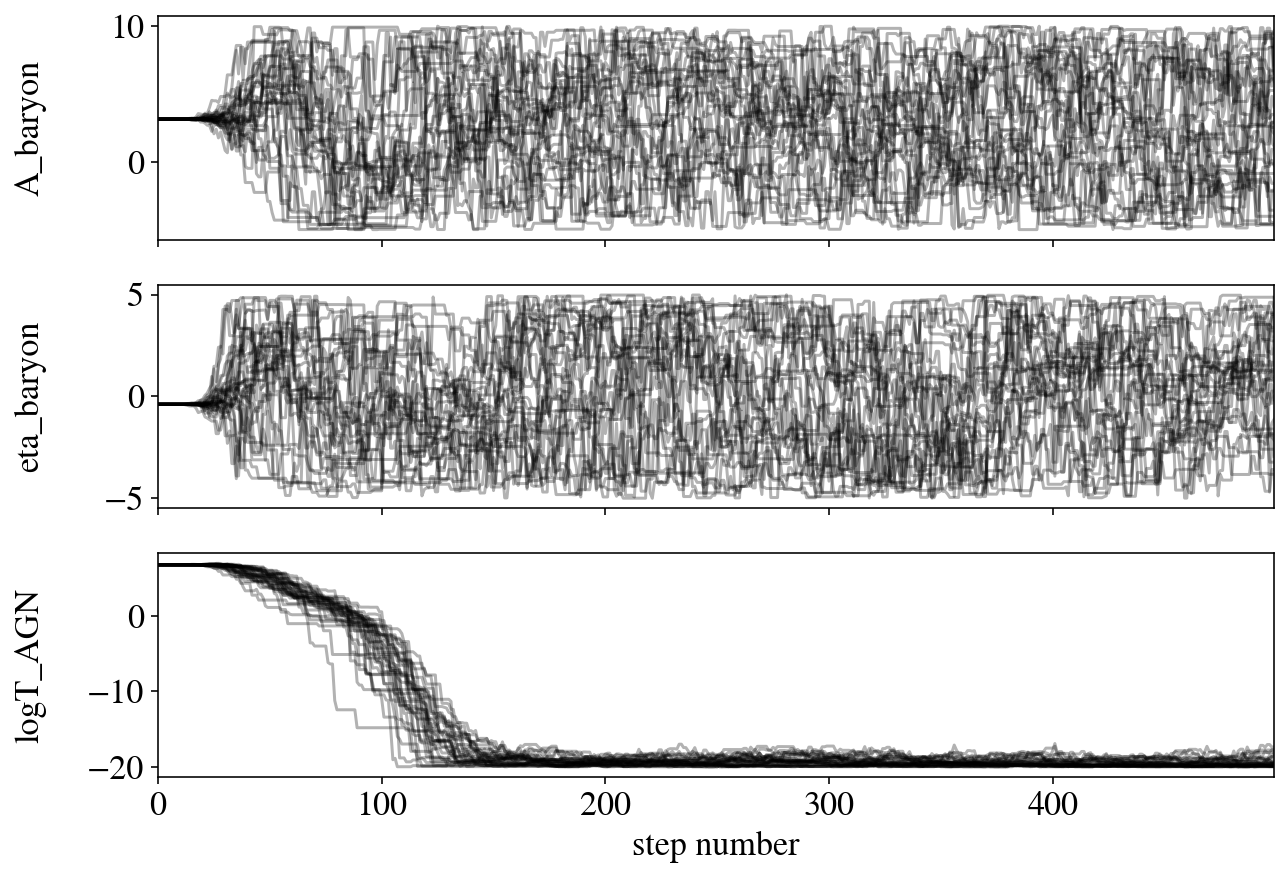

In [21]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ['A_baryon', 'eta_baryon', 'logT_AGN']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');

(928, 3)


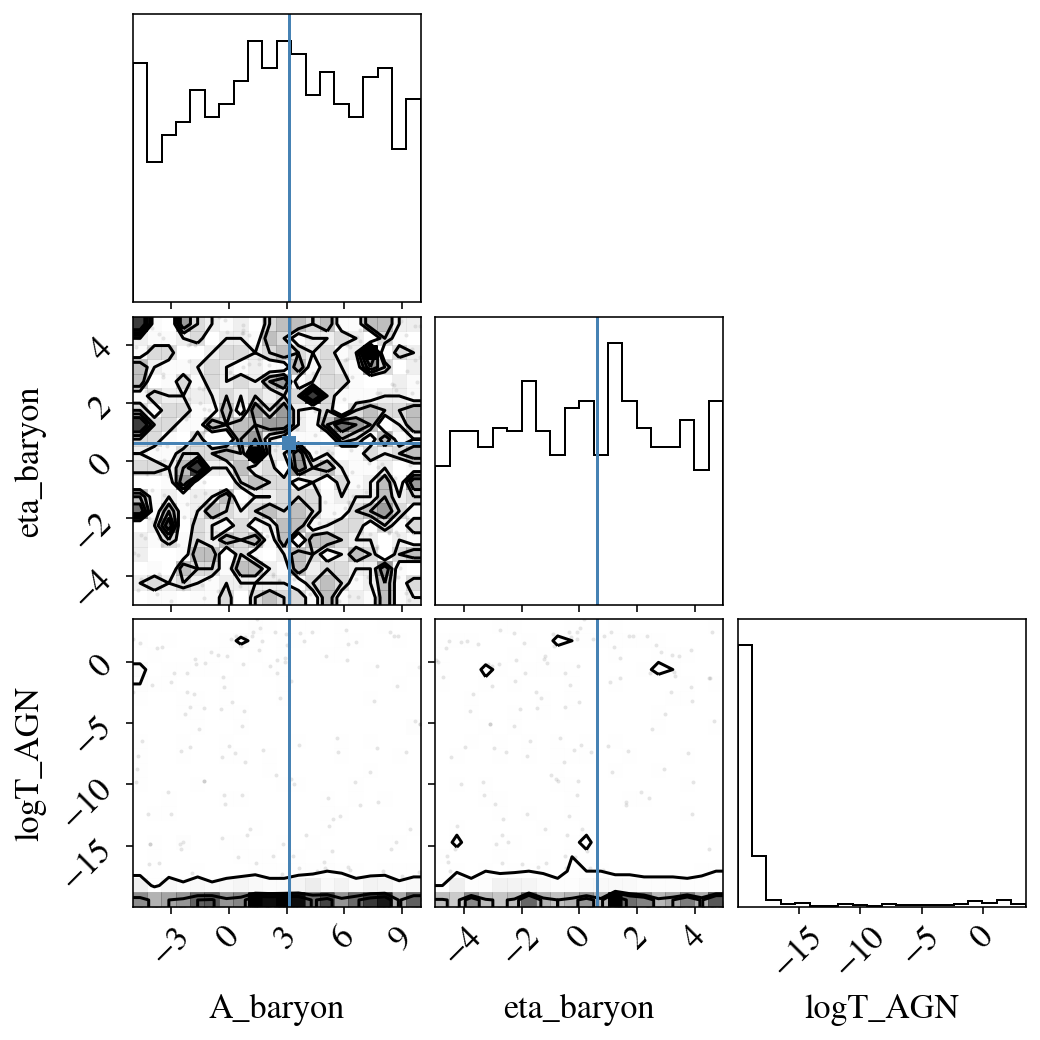

In [14]:
flat_samples = sampler.get_chain(discard=60, thin=15, flat=True) ## not sure about discard and thin values
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, truths=initial);

# Not sure what to put into the 'truths' arg because I don't actually know what values of A, eta, and logT_AGN will
# reproduce the test observational data, so I made equal to HMCode defaults -- might be misunderstanding argument?

(16000, 3)


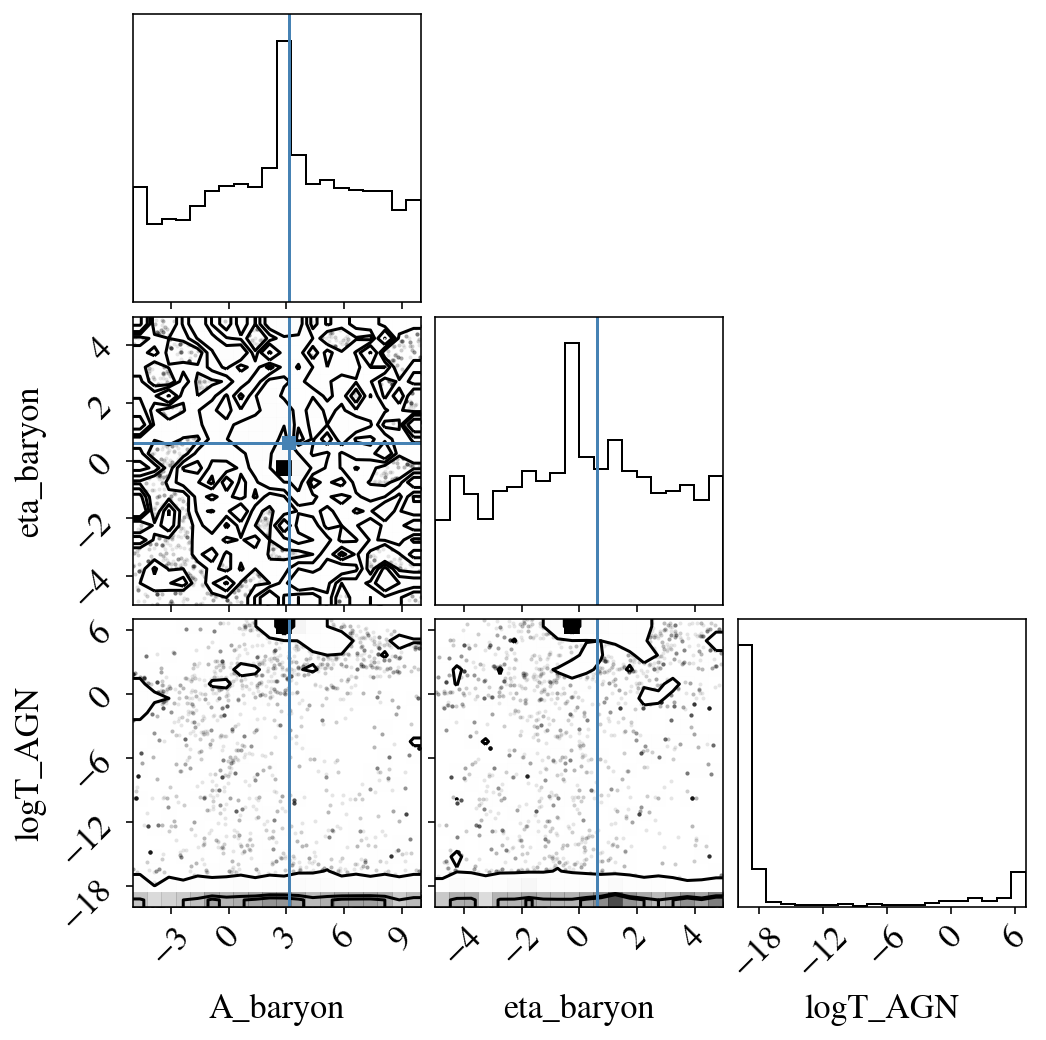

In [28]:
flat_samples = sampler.get_chain(flat=True) ## not sure about discard and thin values
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, truths=initial);

In [15]:
labels = ['A-baryon', 'eta-baryon', 'logT_{AGN}']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Quick plot for sanity check

In [16]:
def baryon_feedback(A, eta, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A, 
                           HMCode_eta_baryon = eta, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return kh, pk[0]

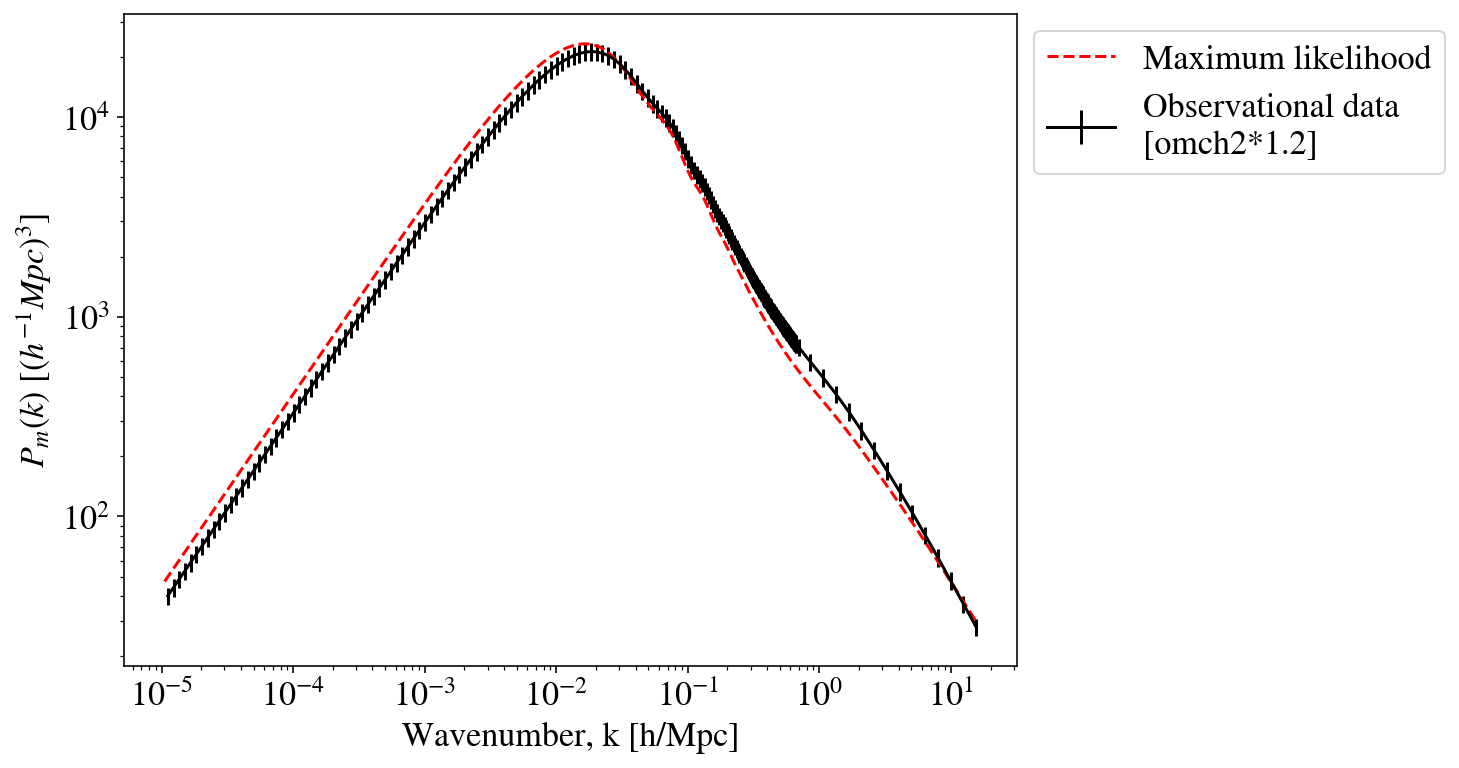

In [33]:
kh_model, pk_model = baryon_feedback(2.605, 0.156, -19.359)

plt.figure(figsize=(8,6))
plt.errorbar(kh_data, pk_data, yerr=pk_err, color='k', label='Observational data\n[omch2*1.2]')
plt.plot(kh_model, pk_model, "--r", label="Maximum likelihood")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
plt.xlabel('Wavenumber, k [h/Mpc]');